# [서포트벡터머신]
유방암 결과를 분류하는 서포트 벡터 머신 모델을 만들고 predict method 를 이용하여 목표변수 범주를 예측하라. 그리고 모델의 정확도 confusion matrix 를 구하라.
## 1. 데이터 구성하기

In [18]:
#패키지 불러오기

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz

import graphviz


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#경고창 제거
import warnings
warnings.filterwarnings('ignore')

#한글 적용
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm
mpl.rc('font',family= 'Malgun Gothic')
font_manager.get_fontconfig_fonts()
fontname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontname = font_manager.FontProperties(fname=fontname).get_name()
plt.style.use('seaborn-white')
rc('font', family=fontname)

In [4]:
df_raw = pd.read_csv('/home/pirl/Downloads/data2/유방암.csv')
df_raw.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
#결측치 확인
df_raw.isnull().sum()

diagnosis                  0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [6]:
df_raw.shape

(569, 31)

In [7]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['diagnosis']
df_raw_x = df_raw.drop('diagnosis', axis=1, inplace=False)

#데이터 분할하기
df_train_x1,df_test_x,df_train_y1,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                              test_size=0.3, random_state=1234)
df_train_x,df_val_x,df_train_y,df_val_y = train_test_split(df_train_x1,df_train_y1,
                                                          test_size=3/7, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("validation data X size : {}".format(df_val_x.shape))
print("validation data Y size : {}".format(df_val_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (227, 30)
train data Y size : (227,)
validation data X size : (171, 30)
validation data Y size : (171,)
test data X size : (171, 30)
test data Y size : (171,)


## 2. 모델 생성

In [8]:
#기본 모델 생성
svm_uncustomized = SVC(random_state=1234)
svm_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set:{:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(svm_uncustomized.score(df_val_x,df_val_y)))

Accuracy on training set:1.000
Accuracy on test set:0.637


과대적합의 문제가 있다.

In [9]:
svm_uncustomized

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1234,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
##svc 모델 parameter 변경
#C : 규제에 대한 강도 변경

#train/ test 정확도 결과 저장용
train_accuracy = []; val_accuracy = []

para_c = [10** c for c in range(-2,2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state=1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    val_accuracy.append(svm.score(df_val_x, df_val_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c['C'] = para_c
df_accuracy_c['TrainAccuracy'] = train_accuracy
df_accuracy_c['ValidationAccuracy'] = val_accuracy

In [12]:
df_accuracy_c.round(3)

,C,TrainAccuracy,ValidationAccuracy
0,0.01,0.63,0.637
1,0.10,0.63,0.637
2,1.00,1.00,0.637
3,10.00,1.00,0.637


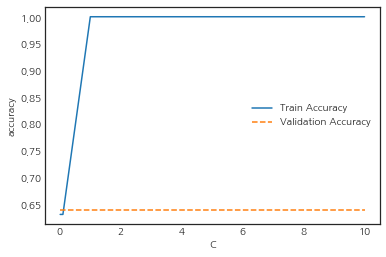

In [13]:
plt.plot(para_c, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_c, val_accuracy, linestyle='--', label='Validation Accuracy')
plt.ylabel('accuracy'); plt.xlabel('C')
plt.legend()

C가 1이상일 경우 train의 정확도는 1로 과대적합의 문제가 있고, test의 정확도는 변화가 없다. 따라서 Csms 0.1로 지정한다.

In [14]:
#Gamma : 훈련 샘플이 미치는 영향의 범위를 변경

#train/ test 정확도 결과 저장용
train_accuracy = []; val_accuracy = []

para_gamma = [10** gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, random_state=1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    val_accuracy.append(svm.score(df_val_x, df_val_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma['gamma'] = para_gamma
df_accuracy_gamma['TrainAccuracy'] = train_accuracy
df_accuracy_gamma['ValidationAccuracy'] = val_accuracy

In [15]:
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,ValidationAccuracy
0,0.01,1.0,0.637
1,0.10,1.0,0.637
2,1.00,1.0,0.637
3,10.00,1.0,0.637


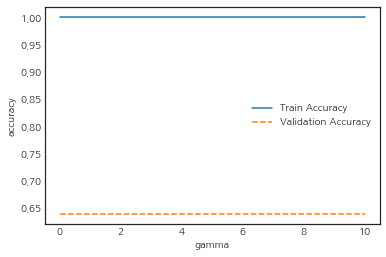

In [16]:
plt.plot(para_gamma, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_gamma, val_accuracy, linestyle='--', label='Validation Accuracy')
plt.ylabel('accuracy'); plt.xlabel('gamma')
plt.legend()

gamma의 변화가 정확도에 영향을 미치지 않는다.

In [19]:
##scale 변환 
#standardscaler : 설명변수 값의 구간을 동일하게 변경

v_feature_name = df_train_x.columns

scaler =StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [20]:
df_scaled_train_x1, df_scaled_test_x = train_test_split(df_scaled, test_size=0.3, random_state=1234)
df_scaled_train_x, df_scaled_val_x = train_test_split(df_scaled_train_x1, test_size=3/7, random_state=1234)

print('train data X size: {}'.format(df_scaled_train_x.shape))
print('validation data X size: {}'.format(df_scaled_val_x.shape))
print('test data X size: {}'.format(df_scaled_test_x.shape))

train data X size: (227, 30)
validation data X size: (171, 30)
test data X size: (171, 30)


In [21]:
#scale 조절 후 SVC 모델 재실행 : scale이 조정된 데이터로 새로운 모델 생성
svm_scaled =SVC(random_state=1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)
print("Accuracy on training set:{:.3f}".format(svm_scaled.score(df_scaled_train_x, df_train_y)))
print("Accuracy on validation set:{:.3f}".format(svm_scaled.score(df_scaled_val_x,df_val_y)))

Accuracy on training set:0.996
Accuracy on validation set:0.965


기존의 서포트 벡터 머신 모델의 정확도와 비교했을 때, 과대적합 문제와 정확도가 낮았던 문제를 해결할 수 있었다.

In [22]:
#C규제에 대한 강도 변경
#train/ test 정확도 결과 저장용
train_accuracy = []; val_accuracy = []

para_c = [10** c for c in range(-2,2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state=1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    val_accuracy.append(svm.score(df_scaled_val_x, df_val_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c['C'] = para_c
df_accuracy_c['TrainAccuracy'] = train_accuracy
df_accuracy_c['ValidationAccuracy'] = val_accuracy

In [23]:
df_accuracy_c.round(3)

,C,TrainAccuracy,ValidationAccuracy
0,0.01,0.630,0.637
1,0.10,0.974,0.947
2,1.00,0.996,0.965
3,10.00,0.996,0.959


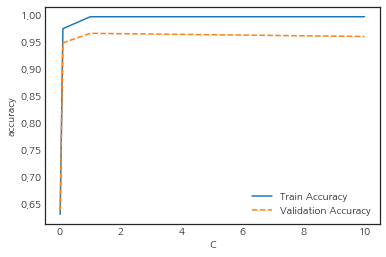

In [24]:
plt.plot(para_c, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_c, val_accuracy, linestyle='--', label='Validation Accuracy')
plt.ylabel('accuracy'); plt.xlabel('C')
plt.legend()

C가 1일 때 많은 증가를 보인다.

In [25]:
#Gamma : 훈련 샘플이 미치는 영향의 범위를 변경
train_accuracy=[]; val_accuracy=[]

para_gamma = [10**gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm=SVC(gamma=v_gamma, C=1, random_state=1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    val_accuracy.append(svm.score(df_scaled_val_x, df_val_y))

df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma['gamma'] = para_gamma
df_accuracy_gamma['TrainAccuracy'] = train_accuracy
df_accuracy_gamma['ValidationAccuracy'] = val_accuracy

In [26]:
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,ValidationAccuracy
0,0.01,0.987,0.971
1,0.10,0.996,0.947
2,1.00,1.000,0.637
3,10.00,1.000,0.637


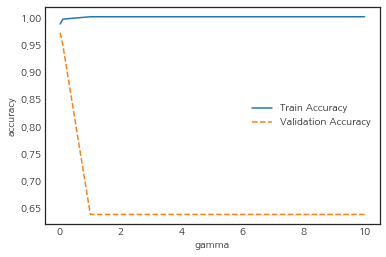

In [27]:
plt.plot(para_gamma, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_gamma, val_accuracy, linestyle='--', label='Validation Accuracy')
plt.ylabel('accuracy'); plt.xlabel('gamma')
plt.legend()

gamma 가 1이상일대는 과대적합이 됨을 볼 수 있다. 따라서 gamma 는 0.1로 지정한다.
## 3. 결론 도출

In [29]:
svc_final = SVC(gamma = 0.1, C=1, random_state=1234)
svc_final.fit(df_scaled_train_x, df_train_y)

y_pred = svc_final.predict(df_scaled_test_x)

print("Accuracy on training set:{:.3f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(svc_final.score(df_scaled_test_x,df_test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set:0.996
Accuracy on test set:0.918
Confusion matrix:
[[99  6]
 [ 8 58]]


In [30]:
#GridSearchCv를 이용한 최적 parameter 찾기

estimator = SVC(random_state=1234)

param_grid = {'C': para_c, "gamma": para_gamma}

grid_rf = GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1)
grid_rf.fit(df_scaled_train_x, df_train_y)
print('best estimator model:\n{}'.format(grid_rf.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_rf.best_params_))
print('nbest score:\n{}'.format(grid_rf.best_score_.round(3)))

best estimator model:
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1234, shrinking=True,
  tol=0.001, verbose=False)

best parameter:
{'C': 10, 'gamma': 0.01}
nbest score:
0.982


### @모델에 대한 결과 해석@

**1. 기본 옵션으로 생성된 모델은 과대적합의 문제가 있어 scale 변환 후, parameter 조정을 실시한다.**


**2. C(규제에 대한 강도)를 1로, gamma(훈련 샘플이 미치는 영향의 범위)를 0.1로 조정했다. 하지만 이것은 정확도는 올랐지만 과대적합의 문제는 아직 남아있다. GridSearchCV를 이용한 최적의 parameter를 찾아보기로 한다.**


**3. 최적의 parameter 를 GridSearchCV를 이용하여 보게되면 규제에 대한 강도를 2, 훈련 샘플이 미치는 영향의 범위를 0.1일 때 정확도가 98.2%로 가장 높다. 높은 정확도가 나왔기때문에 암진단에 사용하기에 적절하다고 생각된다.**

* 서포트벡터머신은 scale에 영향을 많이 받기때문에 적절한 C와 gamma를 찾기 전에 scale 변환이 선행 되어야한다.